# A Breef Data Science Pipeline - Part 2

#### [Institute of Data Science at Maastricht University](https://www.maastrichtuniversity.nl/research/institute-data-science)
---

## Data Exploration
---

Data Dimension Milestones
- Strategy (Research Questions)
- Datasets Treatment
- Variables Analysis
- Descriptive Statistics

The first step to any data analysis project is to define the question or problem we're looking to solve and to define a measure (or set of measures) for our success at solving that task. The data analysis checklist has us answer a handful of questions to accomplish that. 

![](../img/eda.png)  
*Image credit:mooc.guokr.com*

---
- ### Strategy

Is important to literally draw the data pipeline strategy that fits with the research questions. The milestones for the analysis should be clear from the beginning with measurable deliverables, so for instance;

- Define the metric for success. Score? Accuracy? A number of iterations? Reproducibility?
- Define the type of data analytic method (e.g. exploration, association causality) before getting into the data
- Understand the context of the question and the scientific or business application (e.g. Are we doing a one-time analysis? Are we creating a model? Are we creating an application? Are we doing a visual report? 
- Record the experimental design
- Nevertheless, are we considering whether the question could be answered with the available data?
- Define the tools and libraries we need for the exploration

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
%matplotlib inline

- Dataset name: Crime, type of crime, municipality  
- Additional Information: [Source](https://data.overheid.nl/data/dataset/misdrijven-soort-misdrijf-gemeente), 
[Metadata](https://politieopendata.cbs.nl/portal.html?_la=nl&_catalog=Politie&graphtype=Table&tableId=47004NED&_theme=66), 
[License](https://data.overheid.nl/licenties-voor-hergebruik) CC-BY 4.0  

---
- ### Datasets Treatment

In [2]:
df_crimentype = pd.read_csv('../data/crime/crimes_type.tsv', sep='\t', index_col=0)
df_crimentype.head()

,CategoryGroupID,Description,Key,Title,CrimeType
0,NaN,NaN,T001160,Alle misdrijven,all crimes
1,NaN,NaN,A025248,HIC: High Impact Criminaliteit - totaal,HIC: High Impact Crime - total
2,NaN,NaN,A025249,"HIC: Diefstal/inbraak woning, totaal","HIC: Theft / burglary dwelling, total"
3,NaN,NaN,A028970,"HIC: Diefstal/inbraak woning, voltooid","HIC: Theft / burglary dwelling, complete"
4,NaN,NaN,A025250,"HIC: Diefstal/inbraak woning, pogingen","HIC: Theft / burglary dwelling, attempts"


In [3]:
df_crime = pd.read_csv('../data/crime/47004NED_UntypedDataSet_20022018_134938.csv', sep=';')
df_crime = df_crime.loc[:, df_crime.columns != 'ID']

In [4]:
# Access the rest of the tables via API
df_municipalities = json_normalize(json.loads(requests.get('https://dataderden.cbs.nl/ODataApi/OData/47004NED/Gemeenten').text)['value'])
df_properties = json_normalize(json.loads(requests.get('https://dataderden.cbs.nl/ODataApi/OData/47004NED/DataProperties').text)['value'])
df_periods = json_normalize(json.loads(requests.get('https://dataderden.cbs.nl/ODataApi/OData/47004NED/Perioden').text)['value'])

In [5]:
# Merge the tables of categories
df_crime = pd.merge(df_crime, df_municipalities, left_on='Gemeenten', right_on='Key', how='left')
df_crime = pd.merge(df_crime, df_crimentype, left_on='SoortMisdrijf', right_on='Key', how='left')

In [6]:
# Process periods
temp = df_crime[df_crime['Perioden'] == '2017HJ01']
temp = temp.copy()
temp.loc[:,'Misdrijven_1'] = df_crime[df_crime['Perioden'] == '2017HJ01']['Misdrijven_1'].multiply(2)
temp.loc[:,'Perioden'] = '2017JJ00'
df_crime = df_crime.append(temp)
df_crime = df_crime[(df_crime['Perioden'] != '2015HJ01') & (df_crime['Perioden'] != '2016HJ01') & (df_crime['Perioden'] != '2017HJ01')]

In [7]:
# Define the variables to make it dataframe
df_crime = df_crime[['Perioden','Gemeenten','Misdrijven_1','CrimeType']]
df_crime.columns = ['Perioden','CBScode','Crimes','CrimeType']

In [8]:
# Taking apart the aggregate summary of the country
df_crime = df_crime[(df_crime['CBScode'] != 'NL0000') & (df_crime['CBScode'] != 'GM0000')]
df_crime = df_crime[(df_crime['CrimeType'] != 'all crimes') &
                    (df_crime['CrimeType'] != 'HIC: High Impact Crime - total') &
                    (df_crime['CrimeType'] != 'HIC: Theft / burglary dwelling, total')]

In [9]:
df_crime.head(10)

,Perioden,CBScode,Crimes,CrimeType
7512,2014JJ00,GM1680,38.0,"HIC: Theft / burglary dwelling, complete"
7514,2015JJ00,GM1680,71.0,"HIC: Theft / burglary dwelling, complete"
7516,2016JJ00,GM1680,39.0,"HIC: Theft / burglary dwelling, complete"
7518,2014JJ00,GM0738,23.0,"HIC: Theft / burglary dwelling, complete"
7520,2015JJ00,GM0738,28.0,"HIC: Theft / burglary dwelling, complete"
7522,2016JJ00,GM0738,7.0,"HIC: Theft / burglary dwelling, complete"
7524,2014JJ00,GM0358,54.0,"HIC: Theft / burglary dwelling, complete"
7526,2015JJ00,GM0358,47.0,"HIC: Theft / burglary dwelling, complete"
7528,2016JJ00,GM0358,60.0,"HIC: Theft / burglary dwelling, complete"
7530,2014JJ00,GM0197,43.0,"HIC: Theft / burglary dwelling, complete"


---
- ### Variables Analysis

Nothing is as important as getting to know your data, the only way to achieve data is analysing variables over and over with different configurations, also feel free to create new features as needed, then we have a look at descriptive statistics.

In [10]:
df_crime['Perioden'].unique()

array(['2014JJ00', '2015JJ00', '2016JJ00', '2017JJ00'], dtype=object)

In [11]:
crimeTypes = df_crime['CrimeType'].unique()
crimeTypes

array(['\xa0\xa0HIC: Theft / burglary dwelling, complete',
       '\xa0\xa0HIC: Theft / burglary dwelling, attempts',
       'HIC: Violent Crime', 'HIC: Street Roof', 'HIC: Robberies',
       'Undermining public order', 'Threat', 'Fire / Explosion',
       'Theft of moped, moped, bike', 'Theft of / from vehicles',
       'Theft of motor vehicles',
       'Theft / burglary companies / institutions',
       'Theft / burglary garage / barn / shed', 'Drug trafficking',
       'Trespassing', 'mistreatment', 'Overt violence (person)',
       'Or destruction. cause damage', 'Arms Trade', 'pickpocketing',
       'morals Felony'], dtype=object)

Before we go to the next step and having the data on hand, we should continue to ask questions:
- Do we still have the same research questions?
- De we still have the same strategy?
- Shall we find other sources?

---

## Data Integration
---

Data Dimension Milestones
- Merge & Aggregate
- Clean
- Explore Distributions
- Descriptive Statistics

![](../img/merge.png)

The next step is to look at the data we're working with. Even curated data sets from the government can have errors in them, and it's vital that we spot these errors before investing too much time in our analysis, we're looking to answer the following questions:

- Did we integrate all raw data?
- Write scripts for cleaning and aggregation
- Is there anything wrong with the data?
- Are there any outliers with the data?
- Do I need to fix or remove any of the data?
- Do we need other sources? (wiki)

---
- ### Merge & Aggregate

In [12]:
# Aggregate by type of crime in every column
df_crimes_table = pd.DataFrame()
for column in crimeTypes:
    crime = df_crime[df_crime['CrimeType'] == str(column)].groupby(['CBScode','Perioden']).sum()['Crimes']
    df_crimes_table[str(column)] = crime
    
df_crimes_table.reset_index(level=['CBScode','Perioden'], inplace=True)

In [43]:
df_crimes_table.head()

,CBScode,Perioden,"HIC: Theft / burglary dwelling, complete","HIC: Theft / burglary dwelling, attempts",HIC: Violent Crime,HIC: Street Roof,HIC: Robberies,Undermining public order,Threat,Fire / Explosion,...,Theft / burglary companies / institutions,Theft / burglary garage / barn / shed,Drug trafficking,Trespassing,mistreatment,Overt violence (person),Or destruction. cause damage,Arms Trade,pickpocketing,morals Felony
0,GM0003,2014JJ00,17.0,8.0,82.0,0.0,1.0,1.0,31.0,4.0,...,17.0,2.0,7.0,0.0,47.0,4.0,78.0,0.0,2.0,5.0
1,GM0003,2015JJ00,26.0,7.0,67.0,0.0,0.0,2.0,30.0,2.0,...,22.0,5.0,6.0,1.0,36.0,1.0,57.0,2.0,4.0,4.0
2,GM0003,2016JJ00,24.0,12.0,67.0,0.0,1.0,3.0,27.0,0.0,...,56.0,6.0,2.0,0.0,40.0,0.0,54.0,1.0,3.0,3.0
3,GM0003,2017JJ00,10.0,2.0,72.0,2.0,4.0,4.0,18.0,6.0,...,20.0,8.0,2.0,0.0,46.0,8.0,34.0,0.0,0.0,8.0
4,GM0005,2014JJ00,13.0,5.0,22.0,0.0,1.0,0.0,8.0,0.0,...,10.0,2.0,4.0,0.0,14.0,0.0,80.0,0.0,6.0,0.0


The municipalities names, region and population are missing, we might go for an additional source

In [13]:
# Sometime you just need a little bit of imagination
df_population = pd.read_csv('../data/crime/population_netherlands.tsv', sep='\t')

In [34]:
df_population.head()

,Municipality,CBScode,Province,Population,Population_density(p/km),Municipality Size
0,Appingedam,GM0003,Groningen,12049,507,Small
1,Bedum,GM0005,Groningen,10475,236,Small
2,Bellingwedde,GM0007,Groningen,8908,86,Small
3,"Boer, TenTen Boer",GM0009,Groningen,7465,165,Small
4,Delfzijl,GM0010,Groningen,25686,198,Small


In [26]:
#creates lables for a certain variable spliting by the median
def labels(variable):
    labels = []
    for mun in variable:
        if mun < variable.median():
            labels.append('Small')
        elif variable.median():
            labels.append('Big')
    return labels

In [27]:
df_population['Municipality Size'] = labels(df_population['Population'])

In [29]:
# Merge the crimes table and population table
df_crime_pop = pd.merge(df_crimes_table, df_population, on='CBScode', how='left')

---
- ### Clean

In [30]:
df_crime_pop = df_crime_pop.replace([np.inf, -np.inf], np.nan)

In [31]:
df_crime_pop.fillna(0, inplace=True)

In [33]:
df_crime_pop.sort_values('CBScode').head(10)

,CBScode,Perioden,"HIC: Theft / burglary dwelling, complete","HIC: Theft / burglary dwelling, attempts",HIC: Violent Crime,HIC: Street Roof,HIC: Robberies,Undermining public order,Threat,Fire / Explosion,...,Overt violence (person),Or destruction. cause damage,Arms Trade,pickpocketing,morals Felony,Municipality,Province,Population,Population_density(p/km),Municipality Size
0,GM0003,2014JJ00,17.0,8.0,82.0,0.0,1.0,1.0,31.0,4.0,...,4.0,78.0,0.0,2.0,5.0,Appingedam,Groningen,12049.0,507.0,Small
1,GM0003,2015JJ00,26.0,7.0,67.0,0.0,0.0,2.0,30.0,2.0,...,1.0,57.0,2.0,4.0,4.0,Appingedam,Groningen,12049.0,507.0,Small
2,GM0003,2016JJ00,24.0,12.0,67.0,0.0,1.0,3.0,27.0,0.0,...,0.0,54.0,1.0,3.0,3.0,Appingedam,Groningen,12049.0,507.0,Small
3,GM0003,2017JJ00,10.0,2.0,72.0,2.0,4.0,4.0,18.0,6.0,...,8.0,34.0,0.0,0.0,8.0,Appingedam,Groningen,12049.0,507.0,Small
4,GM0005,2014JJ00,13.0,5.0,22.0,0.0,1.0,0.0,8.0,0.0,...,0.0,80.0,0.0,6.0,0.0,Bedum,Groningen,10475.0,236.0,Small
5,GM0005,2015JJ00,0.0,2.0,22.0,0.0,0.0,0.0,10.0,0.0,...,0.0,64.0,0.0,0.0,6.0,Bedum,Groningen,10475.0,236.0,Small
6,GM0005,2016JJ00,10.0,2.0,19.0,0.0,0.0,0.0,5.0,1.0,...,0.0,44.0,0.0,1.0,6.0,Bedum,Groningen,10475.0,236.0,Small
7,GM0005,2017JJ00,12.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16.0,0.0,2.0,4.0,Bedum,Groningen,10475.0,236.0,Small
8,GM0007,2014JJ00,9.0,4.0,35.0,0.0,0.0,0.0,12.0,2.0,...,0.0,30.0,1.0,0.0,3.0,Bellingwedde,Groningen,8908.0,86.0,Small
9,GM0007,2015JJ00,10.0,2.0,31.0,1.0,0.0,1.0,15.0,4.0,...,2.0,28.0,0.0,0.0,5.0,Bellingwedde,Groningen,8908.0,86.0,Small


In [36]:
df_crime_pop.describe()

,"HIC: Theft / burglary dwelling, complete","HIC: Theft / burglary dwelling, attempts",HIC: Violent Crime,HIC: Street Roof,HIC: Robberies,Undermining public order,Threat,Fire / Explosion,"Theft of moped, moped, bike",Theft of / from vehicles,...,Drug trafficking,Trespassing,mistreatment,Overt violence (person),Or destruction. cause damage,Arms Trade,pickpocketing,morals Felony,Population,Population_density(p/km)
count,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000,...,1660.000000,1660.000000,1660.000000,1660.000000,1660.00000,1660.000000,1660.000000,1660.000000,1660.000000,1660.000000
mean,99.620482,45.353614,198.046988,10.748795,2.903012,12.624699,75.557831,11.675904,274.530723,186.609639,...,31.109639,5.398795,112.969880,9.519277,238.98494,11.452410,66.614458,17.216265,40559.891566,762.375904
std,237.118180,115.394471,556.424879,78.809482,12.142399,64.429247,218.738676,23.521266,841.113901,664.478216,...,94.847081,18.095920,310.947401,30.734571,468.64313,38.283099,444.831692,38.820442,66095.047747,962.671769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,8.000000,37.000000,0.000000,0.000000,0.000000,14.000000,2.000000,30.000000,22.000000,...,4.000000,0.000000,20.000000,0.000000,59.00000,1.000000,2.000000,3.000000,15577.000000,193.000000
50%,48.000000,18.000000,76.000000,1.000000,0.000000,2.000000,28.000000,5.000000,78.000000,57.500000,...,11.000000,1.000000,43.000000,3.000000,116.00000,4.000000,9.000000,8.000000,25580.000000,390.000000
75%,87.000000,38.000000,151.000000,3.000000,2.000000,6.000000,59.000000,12.000000,193.000000,136.000000,...,25.000000,3.000000,88.000000,8.000000,227.00000,9.000000,23.000000,17.000000,43180.000000,906.000000
max,3637.000000,1884.000000,7929.000000,1719.000000,198.000000,1534.000000,3320.000000,264.000000,12664.000000,9965.000000,...,1568.000000,265.000000,4356.000000,572.000000,5382.00000,556.000000,9313.000000,530.000000,853312.000000,6131.000000


---
- ### Explore Distributions

How is related the crime and the types of crime with the population?

In [37]:
df_population.describe()

,Population,Population_density(p/km)
count,390.000000,390.000000
mean,43159.884615,811.246154
std,67418.318090,973.824887
min,938.000000,21.000000
25%,17742.000000,225.250000
50%,26046.500000,415.000000
75%,44371.500000,998.000000
max,853312.000000,6131.000000


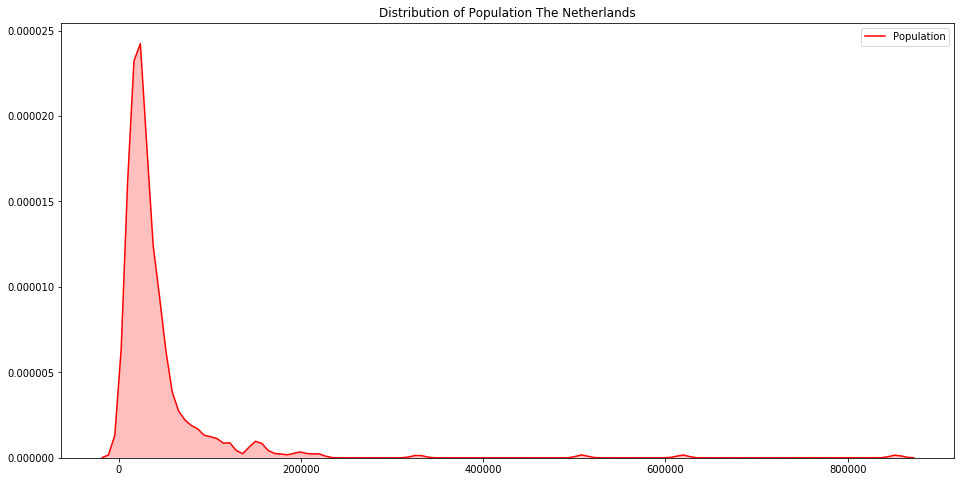

In [38]:
plt.figure(figsize=[16, 8])
sns.kdeplot(df_population['Population'], shade=True, color="r", label='Population')
plt.title('Distribution of Population The Netherlands'); plt.legend()
plt.savefig('../img/population.png')

Next, let's create a **scatterplot matrix**. Scatterplot matrices plot the distribution of each column along the diagonal, and then plot a scatterplot matrix for the combination of each variable. They make for an efficient tool to look for errors in our data.

We can even have the plotting package color each entry by its class to look for trends within the classes.

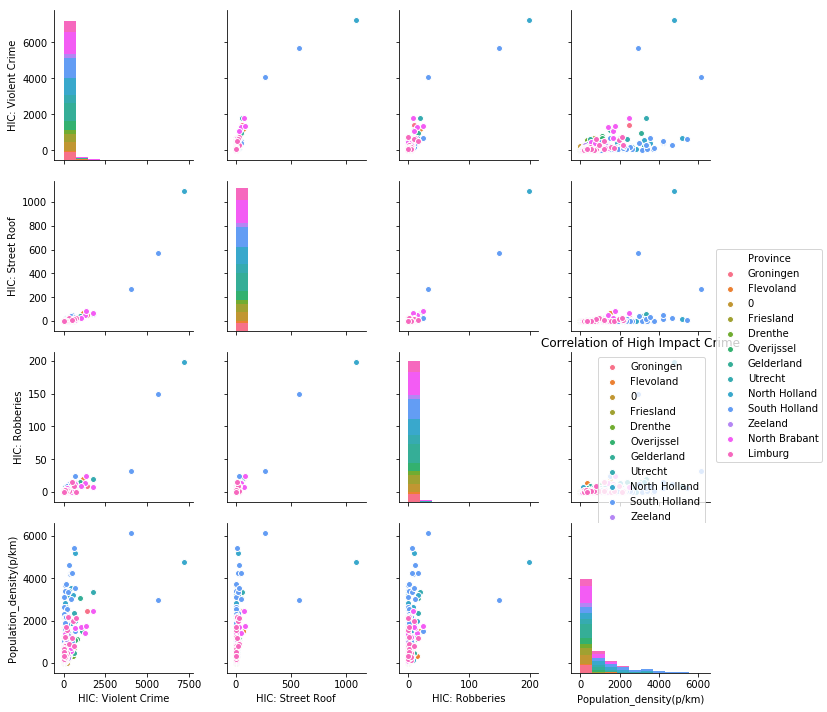

In [75]:
df_plot = df_crime_pop[df_crime_pop['Perioden'] == 
                       '2017JJ00'][['HIC: Violent Crime','HIC: Street Roof', 'HIC: Robberies', 'Population_density(p/km)', 'Province']]
sns.pairplot(df_plot, hue="Province")
plt.title('Correlation of High Impact Crime'); plt.legend()
plt.savefig('../img/correlation.png')

In [78]:
df_plot = df_crime_pop[df_crime_pop['Perioden'] == 
                       '2017JJ00'][['HIC: Violent Crime','Population_density(p/km)', 'Municipality Size']]

In [80]:
df_plotS = df_plot.loc[df_plot['Municipality Size'] == 'Small']
df_plotS = df_plot.loc[df_plot['Municipality Size'] == 'Big']

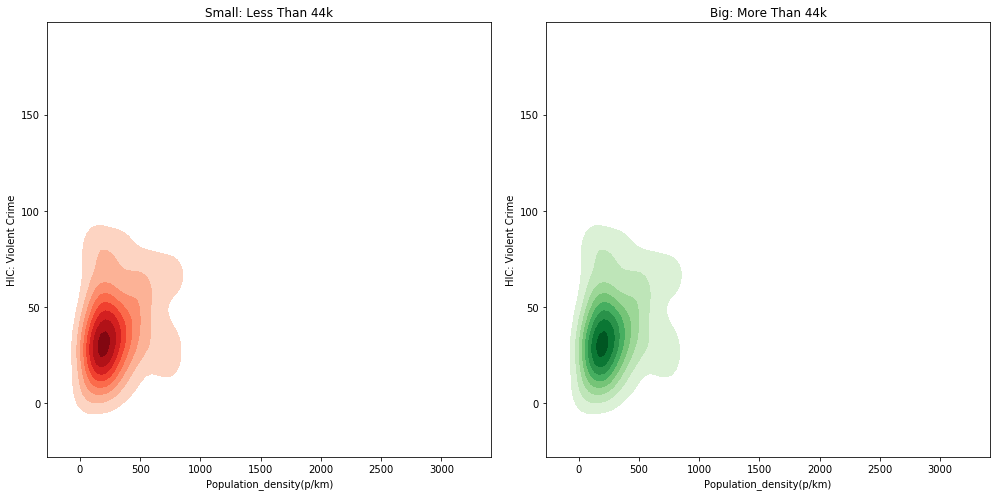

In [84]:
plt.figure(figsize=[14, 7])
plt.subplot(1,2,1)
sns.kdeplot(df_plotS['Population_density(p/km)'], df_plotS['HIC: Violent Crime'], cmap="Reds", shade=True, shade_lowest=False)
plt.title('Small: Less Than 44k')
plt.subplot(1,2,2)
sns.kdeplot(df_plotS['Population_density(p/km)'], df_plotS['HIC: Violent Crime'], cmap="Greens", shade=True, shade_lowest=False)
plt.title('Big: More Than 44k')
plt.tight_layout()

---
- ### Descriptive

By this phase we should be able to make a feature selection, is important to document the variable interpretation, for the future comunication.
- Are the variables correlated? 
- Shall we set new hypothesis
- Do we have a summary of the problem to solev?
- Do we need different variables?
- Do we need to normalize our features?
- Are we still confident we can answer the research question?
- Do we want to make a model or just report the Descriptive Statistics?

If we are ready to the next step, then we create the **Dataset to Ingest to the model**

In [58]:
df_crime_pop.to_csv('../data/crime/crimes_municipality_ingest.tsv', sep='\t', encoding= 'utf-8')

Enough flirting with the data. Let's get to modeling.

### Next: Machine Learning 